<a href="https://colab.research.google.com/github/BLOSSOM1994/testtt/blob/main/sobhani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!pip install keras
!pip install stopwords_guilannlp
!pip install nltk
!pip install hazm


In [95]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from string import punctuation
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [96]:
import re
import hazm 
from stopwords_guilannlp import *
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
#--------------------------------

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
# loading data
df = pd.read_excel('/content/SobhaniComment.xlsx')
df.shape

(2000, 4)

In [98]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Unnamed: 0,0,1
confirmed_at,2018-04-03 14:50:07,2018-04-03 14:49:07
comment,واقعا عالیه .پیشنهاد میکنم بخرید .ضرر نمیکنید,مقداری بلنده\nاگه عادت به بلند بودن بالش نداری...
Label,U0001F970,U0001F970


In [99]:
# Create a new dataframe with two columns
df1 = df[['comment', 'Label']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Label'])]

df1.shape

(2000, 2)

In [100]:
# Percentage of complaints with text
total = df1['Label'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [101]:
pd.DataFrame(df.comment.unique()).values

array([['واقعا عالیه .پیشنهاد میکنم بخرید .ضرر نمیکنید'],
       ['مقداری بلنده\nاگه عادت به بلند بودن بالش ندارید ممکنه اذیت بشید'],
       ['تو پیسنهاد شگفت انگیز خریدم\nخیلی تیز و باکیفیته'],
       ...,
       ['در سه دفعه ای که استفاده کردم،شش تکه مصرف شده و هر بار دو تکه'],
       ['مرتبا خاموش میشه این یعنی فاجعه 24 ساعت سالم وبی نقص نبود'],
       ['من اینو تو شگفت انگیز خریدم \nدوتاهم خریدم \nواقعااا خوشگل و نرمه']],
      dtype=object)

In [102]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
#df2 = df1.sample(10000, random_state=1).copy()

df2=df1.copy()

In [103]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Label'].factorize()[0]
category_id_df = df2[['comment', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'comment']].values)

# New dataframe
df2.head(10)

,comment,Label,category_id
0,واقعا عالیه .پیشنهاد میکنم بخرید .ضرر نمیکنید,U0001F970,0
1,مقداری بلنده\nاگه عادت به بلند بودن بالش نداری...,U0001F970,0
2,تو پیسنهاد شگفت انگیز خریدم\nخیلی تیز و باکیفیته,U0001F600,1
3,اگر این تبلت هم usb c داشت و هم نسبت تصویر 3 ب...,U0001F970,0
4,من برااین خریدمش که مثل پارچ بتونم شیر رو تو ل...,U0001F643,2
5,با سلام\nبنده این مودم رو نزدیک به دو سال هست ...,U0001F33A,3
6,به این برند وقادار هستم و خوشحالم که ایران وار...,U0001F44D,4
7,هم خیلی خوشبوئه هم خوش دسته و هم لباس هامو خیل...,U0001F33A,3
8,خیلی خوبه من واقعا راضیم هم خوشبوئه و من دستام...,U0001F33A,3
9,دستگاه بسیار خوبیه\nاز وقتی که نصب کردم و از آ...,U0001F62F,5


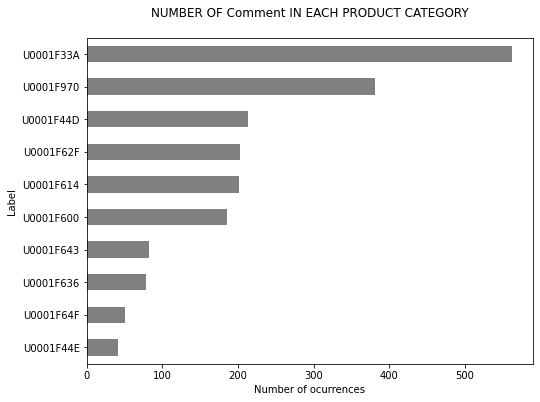

In [104]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Label').comment.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF Comment IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [105]:
normalizer =  hazm.Normalizer()
tokenizer = hazm.SentenceTokenizer()
tokens=hazm.word_tokenize

In [106]:
tfidf = TfidfVectorizer(lowercase=False, preprocessor=normalizer.normalize, tokenizer=tokens,ngram_range=(1, 2))

# We transform each complaint into a vector
dcom=df2.comment
features = tfidf.fit_transform(dcom).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 2000 complaints is represented by 55917 features (TF-IDF score of unigrams and bigrams)


In [107]:


# Finding the three most correlated terms with each of the product categories
#N = 3
#lis=liss=[]
#for Product, category_id in sorted(category_to_id.items()):
 # features_chi2 = chi2(features, labels == category_id)
 # indices = np.argsort(features_chi2[0])
 # feature_names = np.array(tfidf.get_feature_names())[indices]
#  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
 # bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  #print("\n==> %s:" %(Product))
 # lis.append((unigrams[-N:]))
  #liss.append(bigrams[-N:])



In [108]:
X = df2['Label'] # Collection of documents
y = df2['comment'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 0)

In [109]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [110]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.5065,0.011264
RandomForestClassifier,0.2810,0.001369


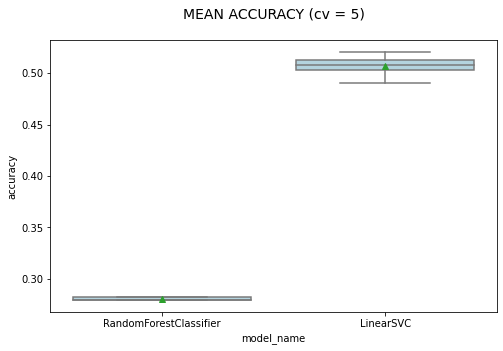

In [111]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [112]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [113]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Label'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

   U0001F970       0.48      0.73      0.58        81
   U0001F600       0.45      0.30      0.36        43
   U0001F643       0.67      0.12      0.20        17
   U0001F33A       0.45      0.83      0.58       143
   U0001F44D       0.64      0.33      0.44        48
   U0001F62F       0.74      0.28      0.40        72
   U0001F636       0.50      0.05      0.09        20
   U0001F614       0.54      0.25      0.34        53
   U0001F44E       0.00      0.00      0.00         8
   U0001F64F       1.00      0.07      0.12        15

    accuracy                           0.49       500
   macro avg       0.55      0.30      0.31       500
weighted avg       0.54      0.49      0.44       500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
conf_mat = confusion_matrix(y_test, y_pred)


In [115]:
#for predicted in category_id_df.category_id:
#  for actual in category_id_df.category_id:
#    if predicted != actual and conf_mat[actual, predicted] >= 20:
#      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
 #                                                          id_to_category[predicted], 
  #                                                         conf_mat[actual, predicted]))
 #   
 #     display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 
 #                                                               'comment']])
 #     print('')

In [116]:
model.fit(features, labels)

#N = 4
#for Product, category_id in sorted(category_to_id.items()):
 # indices = np.argsort(model.coef_[category_id])
 # feature_names = np.array(tfidf.get_feature_names())[indices]
#  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#  print("\n==> '{}':".format(Product))
 # print("  * Top unigrams: %s" %(', '.join(unigrams)))
 # print("  * Top bigrams: %s" %(', '.join(bigrams)))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [118]:
new_complaint = "عالیه بنظرم بخرید خوشتون میاد"
result=fitted_vectorizer.transform([new_complaint])
t=model.predict(result)
i=0
while i<len(df):
  if df['comment'][i]==t:
    emoj=df['Label'][i]
    break
  i+=1


In [119]:
!pip install emoji
import emoji

In [120]:
emo=pd.read_csv('/content/Emoji_Sobhani.csv')
dic=emo.Code

In [137]:
dic

0    U0001F600
1    U0001F643
2    U0001F970
3    U0001F44E
4    U0001F636
5    U0001F614
6    U0001F44D
7    U0001F33A
8    U0001F62F
9    U0001F64F
Name: Code, dtype: object

In [139]:
if emoj == dic[0]:
   print(  "\U0001F600")
if emoj == dic[1]:
   print(   "\U0001F643")
if emoj == dic[2]:
   print(   "\U0001F970")

if emoj == dic[3]:
   print(   "\U0001F44E")

if emoj == dic[4]:
   print(   "\U0001F636")

if emoj == dic[5]:
   print(   "\U0001F614")

if emoj == dic[6]:
   print(   "\U0001F44D")

if emoj == dic[7]:
  print(    "\U0001F33A")

if emoj == dic[8]:
  print(    "\U0001F62F")

if emoj == dic[9]:
   print(   "\U0001F64F")

😯
